In [12]:
from tardis import run_tardis
import networkx as nx
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import xml.etree.ElementTree as et
import requests
import yaml
import os


In [13]:
sim = run_tardis("../../tardis_example.yml",
                 virtual_packet_logging=True,
                 show_convergence_plots=False,
                 export_convergence_plots=False,
                 log_level="ERROR")

Embedding the final state for Jupyter environments


In [14]:
spectrum = sim.spectrum_solver.spectrum_real_packets
spectrum_virtual = sim.spectrum_solver.spectrum_virtual_packets
spectrum_integrated = sim.spectrum_solver.spectrum_integrated

[py.warnings         ][WARNING]  /home/clyde/miniforge3/envs/tardis-installation-test/lib/python3.13/site-packages/astropy/units/format/generic.py:507: UnitsWarning:

'erg/s/Hz' contains multiple slashes, which is discouraged by the FITS standard

 (warnings.py:110)
[py.warnings         ][WARNING]  /home/clyde/miniforge3/envs/tardis-installation-test/lib/python3.13/site-packages/astropy/units/format/generic.py:507: UnitsWarning:

'erg/s/Hz' contains multiple slashes, which is discouraged by the FITS standard

 (warnings.py:110)


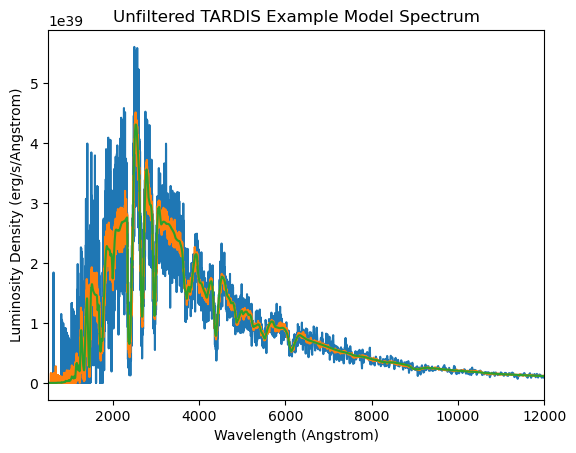

In [15]:
plt.plot(spectrum.wavelength, spectrum.luminosity_density_lambda)
plt.plot(spectrum.wavelength, spectrum_virtual.luminosity_density_lambda)
plt.plot(spectrum.wavelength, spectrum_integrated.luminosity_density_lambda)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Luminosity Density (erg/s/Angstrom)")
plt.xlim(500, 12000)
plt.title("Unfiltered TARDIS Example Model Spectrum")
plt.show()

In [16]:
# Function to get Filter URL from TARDIS config file
def get_url_from_config(config_file_path):
    
    with open(config_file_path, 'r') as f:
        config = yaml.safe_load(f)
        telescope = config['filter']['Telescope_Name']
        instrument = config['filter']['Instrument']
        filter_id = config['filter']['Filter_ID']


    name = f"{telescope}/{instrument}.{filter_id}"
    safe_name = name.replace('/', '.')
    url = f"https://svo2.cab.inta-csic.es/theory/fps/fps.php?ID={name}"

    return url, safe_name

In [17]:
# Function to download the filter file
def download_filter(url, filename):
    req = requests.get(url, timeout = 10)

    with open((f'Filters/{filename}.xml'), 'wb') as f:
            
        # Chunking to avoid large memory consumption
        for chunk in req.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
        
        return filename

In [18]:
# Function to check if the filter file is valid
def check_filter(filter_name):
    
    root = et.parse(f"Filters/{filter_name}.xml")
    
    info = root.find('INFO')
    check = info.get('value')

    if check == 'ERROR':
        return False
    else:
        return True

In [19]:
# Main Execution

# Get URL and Filter Name from config file
url_and_name = get_url_from_config('filter_config.yml')
DownloadUrl = url_and_name[0]
FilterName = url_and_name[1]

# Download the filter file
chosen_filter = download_filter(DownloadUrl, FilterName)

# Check if the filter URL is valid. If not, remove the file and raise an error.
if check_filter(FilterName) == True:
    print("Filter URL is valid. Proceeding with filtering process.")
elif check_filter(FilterName) == False:
    print("Filter URL is not valid. Removing invalid filter file.")
    os.remove(f'Filters/{FilterName}.xml')
    raise ValueError("Invalid Filter URL. The filter file has been removed.")

Filter URL is valid. Proceeding with filtering process.


In [20]:
# To Do Next [For me]: Make it so that we do not have to download the filter to check if the url is valid.

In [21]:
import xml.etree.ElementTree as et

def get_filter(filter_name):
    
    # Parse XML File from Filters Directory 
    root = et.parse(f"Filters/{filter_name}.xml")
    
    # Get wavelength and transmission values in one array (Will be in aleternating order)
    all_vals = np.array([float(x.text) for x in root.findall('.//TD')])

    # Separate wavelength and transmission values
    wl = all_vals[0::2] * u.AA
    tr = all_vals[1::2]
    return wl, tr

def interp_filter(spectrum_to_filter, filter_name):
    #Interpolate filter transmission values to match TARDIS Spectrum
    return np.interp(spectrum_to_filter, get_filter(filter_name)[0], get_filter(filter_name)[1])

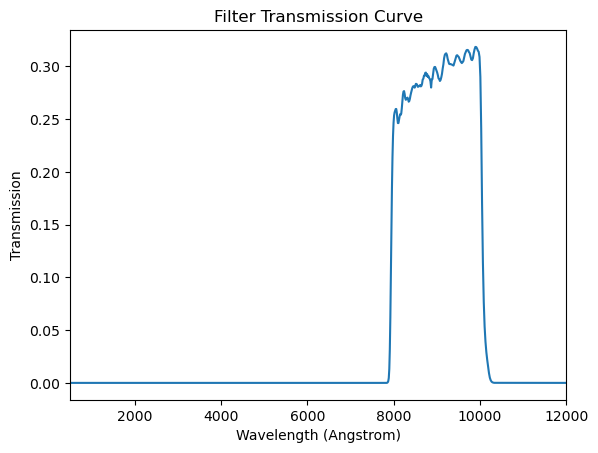

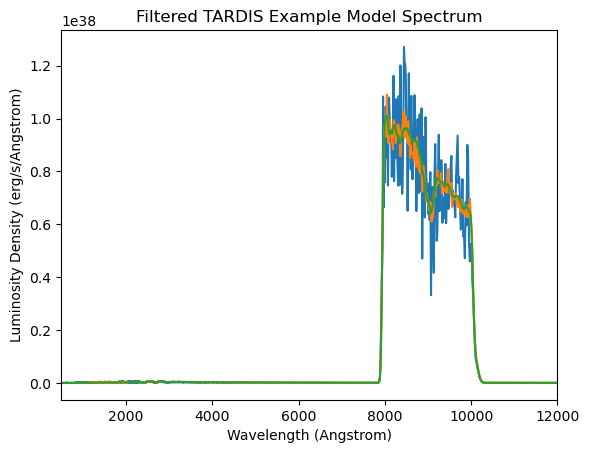

In [22]:
def plot_filtered_spectrum(spectrum, spectrum_virtual, spectrum_integrated, chosen_filter):
    
    # Interpolate filter transmission values to match TARDIS Spectrum
    prepared_filter = interp_filter(spectrum.wavelength, chosen_filter)
    
    # Plot the filter transmission curve
    plt.figure()
    plt.plot(spectrum.wavelength, prepared_filter)
    plt.title("Filter Transmission Curve")
    plt.xlabel("Wavelength (Angstrom)")
    plt.ylabel("Transmission")
    plt.xlim(500, 12000)
    plt.show()

    # Plot the filtered spectra
    plt.figure()
    plt.plot(spectrum.wavelength, spectrum.luminosity_density_lambda * prepared_filter)
    plt.plot(spectrum.wavelength, spectrum_virtual.luminosity_density_lambda * prepared_filter)
    plt.plot(spectrum.wavelength, spectrum_integrated.luminosity_density_lambda * prepared_filter)
    plt.xlabel("Wavelength (Angstrom)")
    plt.ylabel("Luminosity Density (erg/s/Angstrom)")
    plt.xlim(500, 12000)
    plt.title("Filtered TARDIS Example Model Spectrum")
    plt.show()

plot_filtered_spectrum(spectrum, spectrum_virtual, spectrum_integrated, chosen_filter)